In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from node2vec import Node2Vec

In [2]:
# Load Compounds used in the secondary screening
drugs_secondary_screen_df = pd.read_csv('../../data/raw/prism_19q4_repurpose_primaryfiles/secondary-screen-replicate-treatment-info.csv', index_col=0)
drugs_secondary_screen_df.head()

,broad_id,dose,perturbation_type,screen_id,detection_plate,compound_plate,well,name,moa,target,disease.area,indication,smiles,phase
column_name,,,,,,,,,,,,,,
PROS001_PR500_120H_X1_P4:A01::MTS010,BRD-K36788280-001-01-2,0.15625,experimental_treatment,MTS010,PROS001_PR500_120H_X1_P4,PROS001_PR500,A01,ribociclib,CDK inhibitor,"CDK4, CDK6",oncology,breast cancer,CN(C)C(=O)c1cc2cnc(Nc3ccc(cn3)N3CCNCC3)nc2n1C1...,Launched
PROS001_PR500_120H_X1_P4:A02::MTS010,BRD-K88510285-001-50-9,20.00070,positive_control,MTS010,PROS001_PR500_120H_X1_P4,PROS001_PR500,A02,bortezomib,"NFkB pathway inhibitor, proteasome inhibitor","PSMA1, PSMA2, PSMA3, PSMA4, PSMA5, PSMA6, PSMA...",hematologic malignancy,"multiple myeloma, mantle cell lymphoma (MCL)",CC(C)C[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)c1cncc...,Launched
PROS001_PR500_120H_X1_P4:A04::MTS010,BRD-K99749624-001-07-0,0.03910,experimental_treatment,MTS010,PROS001_PR500_120H_X1_P4,PROS001_PR500,A04,linifanib,"PDGFR tyrosine kinase receptor inhibitor, VEGF...","CSF1, CSF1R, FLT1, FLT3, FLT4, KDR, KIT, PDGFR...",NaN,NaN,Cc1ccc(F)c(NC(=O)Nc2ccc(cc2)-c2cccc3[nH]nc(N)c...,Phase 3
PROS001_PR500_120H_X1_P4:A05::MTS010,BRD-K85402309-043-01-9,0.00061,experimental_treatment,MTS010,PROS001_PR500_120H_X1_P4,PROS001_PR500,A05,dovitinib,"EGFR inhibitor, FGFR inhibitor, FLT3 inhibitor...","CSF1R, EGFR, FGFR1, FGFR2, FGFR3, FLT1, FLT3, ...",NaN,NaN,CN1CCN(CC1)c1ccc2nc([nH]c2c1)-c1c(N)c2c(F)cccc...,Phase 3
PROS001_PR500_120H_X1_P4:A06::MTS010,BRD-K50168500-001-07-9,10.00000,experimental_treatment,MTS010,PROS001_PR500_120H_X1_P4,PROS001_PR500,A06,canertinib,EGFR inhibitor,"AKT1, EGFR, ERBB2, ERBB4",NaN,NaN,Fc1ccc(Nc2ncnc3cc(OCCCN4CCOCC4)c(NC(=O)C=C)cc2...,Phase 3


In [3]:
# Only drugs with existing name are taken (NaNs are dropped)
drugs_used = set(drugs_secondary_screen_df["name"].str.upper().to_list())
drugs_used = list(set(item for item in drugs_used if not pd.isna(item)))

print(f"A total of {len(drugs_used)} were used in the study: {drugs_used}")

A total of 1448 were used in the study: ['CHLORPROPAMIDE', 'TRIFLURIDINE', 'IDARUBICIN', 'BETAMETHASONE-DIPROPIONATE', 'RESATORVID', 'FLUTAMIDE', 'ROMIDEPSIN', 'ALMOREXANT', 'LOVASTATIN', 'TRIAMTERENE', 'HEXYLRESORCINOL', 'GENIPIN', 'AZD1480', 'PSI-7976', 'SATRAPLATIN', 'FLUOROMETHOLONE', 'CYCLOVIROBUXIN-D', 'Y-320', 'AM-580', 'NEFIRACETAM', 'PI-828', 'PIRENPERONE', 'PU-H71', 'HYPOESTOXIDE', 'TANESPIMYCIN', 'RIBITOL', 'PRACTOLOL', 'DOFETILIDE', 'BAICALIN', 'TRYPTANTHRIN', 'ACY-1215', 'DESOXYCORTONE', 'AZ3146', 'EPOTHILONE-A', 'SAXAGLIPTIN', 'PETCM', 'CYCLOSPORIN-A', 'BTS-54505', 'OXONIC-ACID', 'ZK811752', 'ABT-737', 'FRENTIZOLE', 'PILOCARPINE', 'ICOTINIB', 'ACDPP', 'VU0238429', 'RABEPRAZOLE', 'CLINDAMYCIN-PHOSPHATE', 'NAVARIXIN', 'CLOMIFENE', 'CCG-50014', 'AG-14361', 'AS-703026', 'CINALUKAST', 'LINIFANIB', 'TG100-115', 'TAK-901', 'PYRIMETHAMINE', 'MEBENDAZOLE', 'ERASTIN', 'GIMERACIL', 'LURASIDONE', 'PHA-848125', 'MITOXANTRONE', 'PIK-75', 'DOMIPHEN', 'DICYCLOVERINE', 'QUINETHAZONE', 'SO

In [4]:
# Load all Compounds 
drug_target_df = pd.read_csv('../../data/raw/prism_repurposing_public_23q2/Repurposing_Public_23Q2_Extended_Primary_Compound_List.csv')

# Create distilled dataset with only secondary screen drugs
drug_target_secondary_screen = drug_target_df[['Drug.Name', 'repurposing_target', 'MOA']]
drug_target_secondary_screen = drug_target_secondary_screen.rename(columns={'Drug.Name': 'DRUG_NAME', 'repurposing_target': 'TARGET', 'MOA': 'TARGET_PATHWAY'})
drug_target_secondary_screen = drug_target_secondary_screen[np.isin(drug_target_secondary_screen['DRUG_NAME'], drugs_used)]
drug_target_secondary_screen = drug_target_secondary_screen.dropna().reset_index(drop=True)
drug_target_secondary_screen.drop_duplicates(inplace = True)

drug_target_secondary_screen

,DRUG_NAME,TARGET,TARGET_PATHWAY
0,8-BROMO-CGMP,PRKG1,PKA ACTIVATOR
1,NORETYNODREL,PGR,PROGESTOGEN HORMONE
2,PREDNISOLONE-ACETATE,NR3C1,GLUCOCORTICOID RECEPTOR AGONIST
3,BETAMETHASONE,NR3C1,GLUCOCORTICOID RECEPTOR AGONIST
4,MEPIVACAINE,SCN10A,"POTASSIUM CHANNEL BLOCKER, SODIUM CHANNEL BLOCKER"
...,...,...,...
1243,PENTOSTATIN,ADA,"ADENOSINE DEAMINASE INHIBITOR, RIBONUCLEOTIDE ..."
1245,TOFOGLIFLOZIN,GCK,SODIUM/GLUCOSE COTRANSPORTER INHIBITOR
1246,MOTESANIB,"FLT1, FLT4, KDR, KIT","KIT INHIBITOR, PDGFR TYROSINE KINASE RECEPTOR ..."
1247,LORLATINIB,ALK,ALK TYROSINE KINASE RECEPTOR INHIBITOR


In [5]:
# Preprocessing for networkx; Each drug a single target for each row
drug_target_secondary_screen_nx  = drug_target_secondary_screen.set_index(['DRUG_NAME', 'TARGET_PATHWAY']).apply(lambda x: x.str.split(',').explode()).reset_index()
drug_target_secondary_screen_nx

,DRUG_NAME,TARGET_PATHWAY,TARGET
0,8-BROMO-CGMP,PKA ACTIVATOR,PRKG1
1,NORETYNODREL,PROGESTOGEN HORMONE,PGR
2,PREDNISOLONE-ACETATE,GLUCOCORTICOID RECEPTOR AGONIST,NR3C1
3,BETAMETHASONE,GLUCOCORTICOID RECEPTOR AGONIST,NR3C1
4,MEPIVACAINE,"POTASSIUM CHANNEL BLOCKER, SODIUM CHANNEL BLOCKER",SCN10A
...,...,...,...
3501,MOTESANIB,"KIT INHIBITOR, PDGFR TYROSINE KINASE RECEPTOR ...",FLT4
3502,MOTESANIB,"KIT INHIBITOR, PDGFR TYROSINE KINASE RECEPTOR ...",KDR
3503,MOTESANIB,"KIT INHIBITOR, PDGFR TYROSINE KINASE RECEPTOR ...",KIT
3504,LORLATINIB,ALK TYROSINE KINASE RECEPTOR INHIBITOR,ALK


In [6]:
PATHWAY_network = drug_target_secondary_screen_nx[['DRUG_NAME', 'TARGET_PATHWAY']].rename(columns={'TARGET_PATHWAY': 'TARGET'})

# Created for large networkx to make drugs more dissimilar from another (this is only a test; needs to be validated)
DRUG_NAME_network = pd.concat([drug_target_secondary_screen_nx['DRUG_NAME'], drug_target_secondary_screen_nx[['DRUG_NAME']].rename(columns= {'DRUG_NAME': 'TARGET'})], axis=1)
DRUG_NAME_network['TARGET'] = DRUG_NAME_network['TARGET'] + '_tar'

secondaryScreen_drug_target_network = drug_target_secondary_screen_nx[['DRUG_NAME', 'TARGET']]
secondaryScreen_drug_target_network.to_csv('../../data/preprocessed/secondaryScreen_drug_target_network.csv')
secondaryScreen_drug_target_network

,DRUG_NAME,TARGET
0,8-BROMO-CGMP,PRKG1
1,NORETYNODREL,PGR
2,PREDNISOLONE-ACETATE,NR3C1
3,BETAMETHASONE,NR3C1
4,MEPIVACAINE,SCN10A
...,...,...
3501,MOTESANIB,FLT4
3502,MOTESANIB,KDR
3503,MOTESANIB,KIT
3504,LORLATINIB,ALK


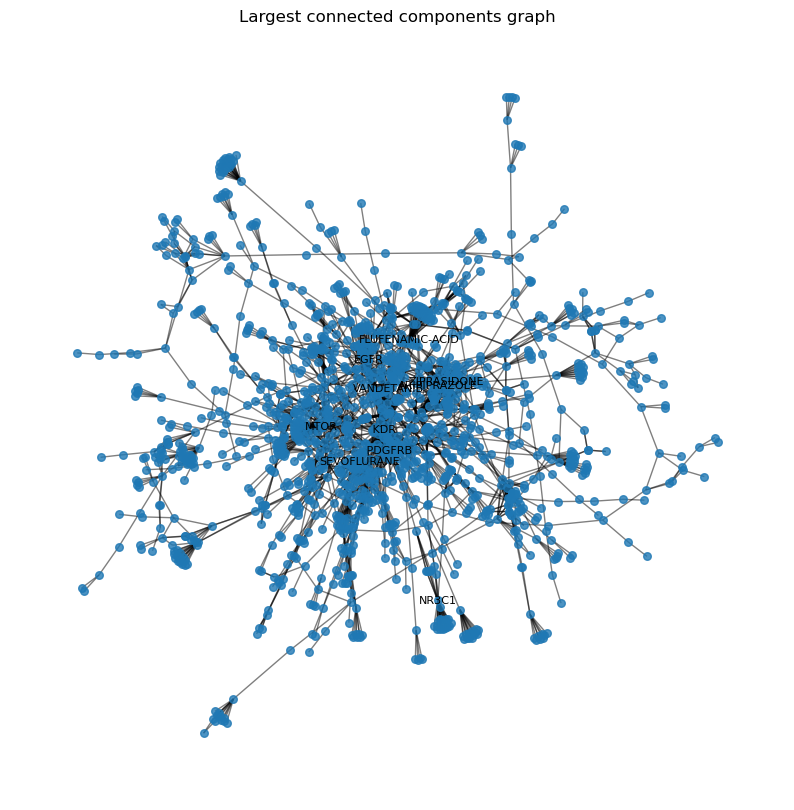

In [7]:
# Plot compound pathway graph
g = nx.from_pandas_edgelist(secondaryScreen_drug_target_network, source='DRUG_NAME', target='TARGET')

largest_component = max(nx.connected_components(g), key=len)
g = g.subgraph(largest_component)

pos = nx.spring_layout(g)
plt.figure(figsize=(10, 10))

nx.draw_networkx_edges(g, pos, alpha=0.5)
nx.draw_networkx_nodes(g, pos, node_size=30, alpha=0.8)

# Get nodes with highest degree centrality
degree_centrality = nx.degree_centrality(g)
top_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]

node_labels = {node: node if node in top_nodes else '' for node in g.nodes()}
nx.draw_networkx_labels(g, pos, labels=node_labels, font_size=8)

plt.axis('off')
plt.title("Largest connected components graph")
plt.show()

In [8]:
# Create large network with pathway and target information of compounds 
large_network = pd.concat([secondaryScreen_drug_target_network, PATHWAY_network], axis=0).drop_duplicates()
# large_network = pd.concat([secondaryScreen_drug_target_network, PATHWAY_network, DRUG_NAME_network], axis=0).drop_duplicates()

g_large = nx.from_pandas_edgelist(large_network, 'DRUG_NAME', 'TARGET')
large_network.to_csv('../../data/preprocessed/secondaryScreen_drug_target_pathway_network.csv')

In [9]:
# Learn low dimensional representation of a large graph
node2vec = Node2Vec(g_large, dimensions=500, walk_length=20, num_walks=200, workers=7) 
model = node2vec.fit(window=10, min_count=1, batch_words=4) 
node2vec_embedding = pd.DataFrame({drugname: model.wv[drugname] for drugname in secondaryScreen_drug_target_network['DRUG_NAME']})
node2vec_embedding.to_csv('../../data/preprocessed/node2vec_embedding.csv')
node2vec_embedding

Generating walks (CPU: 1): 100%|██████████| 29/29 [00:23<00:00,  1.25it/s]


,8-BROMO-CGMP,NORETYNODREL,PREDNISOLONE-ACETATE,BETAMETHASONE,MEPIVACAINE,METOPROLOL,METHSCOPOLAMINE,TERFENADINE,SB-218078,GALETERONE,...,JTE-607,LY3023414,LITRONESIB,ERDAFITINIB,FENRETINIDE,PENTOSTATIN,TOFOGLIFLOZIN,MOTESANIB,LORLATINIB,GSK2830371
0,0.457079,-0.480747,0.432444,0.508053,0.927028,0.188641,-0.081545,1.209914,0.160667,0.307012,...,1.503550,0.275699,0.020417,0.059677,-0.161351,0.264470,-0.340444,0.501635,-0.085501,-0.664572
1,-0.191598,0.492798,0.130096,0.183448,0.428147,0.387316,0.034554,1.084742,0.296595,-0.193019,...,-0.834198,-0.133783,0.328599,-1.768497,0.112045,-0.240391,-0.041384,-0.292650,0.119854,0.125383
2,0.475686,-0.620497,0.170778,0.184930,-0.536499,0.438441,0.186923,0.088425,-0.072140,0.749679,...,-0.277413,-0.421962,0.449611,-0.093629,-0.046776,0.205634,0.491770,0.348109,0.264080,-0.557743
3,0.516158,0.801933,0.616266,0.692585,-0.117215,0.425955,-0.957677,-0.296204,0.343743,0.646011,...,0.147191,0.577709,0.282858,-0.976608,0.044552,-0.405033,-0.325513,1.405949,-0.366328,0.472305
4,0.330148,-0.775088,-0.597154,-0.644298,-0.382721,-0.716264,0.935616,1.129782,-0.006312,-0.180954,...,-0.940444,-0.205040,-0.068240,-0.477994,-0.113075,-0.302283,-0.502722,0.088196,-0.628448,-0.069066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1.178450,0.096970,-0.763317,-0.822424,0.444166,0.208372,-0.451808,0.068828,0.582351,-0.758996,...,0.927386,0.134680,0.232361,-0.731030,0.520318,0.554306,0.056629,-0.733662,-0.323969,-0.001223
496,0.526636,-0.858183,0.192750,0.447986,-0.412281,0.195893,0.565353,1.827356,-0.182883,-0.124876,...,0.197158,-0.018248,0.115181,-1.113088,-0.164272,-0.112076,0.415543,-0.531015,0.030620,0.442818
497,1.132287,-0.024002,0.043125,-0.060237,0.394538,0.203275,-0.593802,-0.723439,-0.040230,0.026576,...,-0.019996,-0.382047,0.326077,-1.075778,0.141937,-0.038574,0.428478,0.558407,-0.337616,0.648099
498,0.350497,-0.435458,-0.440686,-0.469684,-0.149028,-0.020106,0.662456,1.169826,0.136685,-0.283044,...,0.018682,-0.057676,0.039589,-0.349273,-0.445787,0.460669,0.457591,-0.496487,0.257666,-0.078433


## Embedding Distance Calculations

In [10]:
from numpy import dot
from numpy.linalg import norm

def cos(a,b):
    return dot(a, b)/(norm(a)*norm(b))
print(cos(node2vec_embedding['POZIOTINIB'], node2vec_embedding['DACOMITINIB']))
print(cos(node2vec_embedding['POZIOTINIB'], node2vec_embedding['CISPLATIN']))
print(cos(node2vec_embedding['VEMURAFENIB'], node2vec_embedding['DABRAFENIB']))
print(cos(node2vec_embedding['VEMURAFENIB'], node2vec_embedding['CISPLATIN']))
print(cos(node2vec_embedding['VEMURAFENIB'], node2vec_embedding['DACOMITINIB']))


0.974211
0.09028668
0.58573395
0.037891667
0.011821547


In [11]:
res = []
filt = np.isin(node2vec_embedding.columns, drugs_used)

filtered_node2vec_embedding  = node2vec_embedding.iloc[:, filt]

dat = np.array(filtered_node2vec_embedding)

for row in range(dat.shape[1]):
#for row in range(50):
    if row%200==0:
        print(row)
        
    cols = []
    for col in range(dat.shape[1]):
        cols.append(cos(dat[:,row], dat[:,col]))
    res.append(np.array(cols))

0
200
400
600
800
1000


In [12]:
results = np.stack(res, axis=0)
results.shape
np.fill_diagonal(results,0)

In [13]:
results.argmax()

944321

In [14]:
results_frame = pd.DataFrame(results, index = filtered_node2vec_embedding.columns, columns = filtered_node2vec_embedding.columns)

In [15]:
results_frame_long = results_frame.melt(ignore_index=False)

In [16]:
sorted_values = results_frame_long.sort_values('value', ascending=False)
sorted_values

,variable,value
PF-3845,PF-04457845,0.999501
PF-04457845,PF-3845,0.999501
SU3327,BI-78D3,0.999449
BI-78D3,SU3327,0.999449
MAXACALCITOL,DOXERCALCIFEROL,0.999416
...,...,...
TROPISETRON,FLUTAMIDE,-0.528531
NMS-873,GAMMA-AMINOBUTYRIC-ACID,-0.529097
GAMMA-AMINOBUTYRIC-ACID,NMS-873,-0.529097
ORNITHINE,FELBAMATE,-0.538321


In [17]:
sorted_values.to_numpy()[:50]

array([['PF-04457845', 0.9995009899139404],
       ['PF-3845', 0.9995009899139404],
       ['BI-78D3', 0.9994492530822754],
       ['SU3327', 0.9994492530822754],
       ['DOXERCALCIFEROL', 0.9994155764579773],
       ['MAXACALCITOL', 0.9994155764579773],
       ['IMIDAPRIL', 0.9993972778320312],
       ['TEMOCAPRIL', 0.9993972778320312],
       ['PROTIRELIN', 0.9993855953216553],
       ['TALTIRELIN', 0.9993855953216553],
       ['PARICALCITOL', 0.9993559122085571],
       ['DOXERCALCIFEROL', 0.9993559122085571],
       ['KPT-276', 0.999218225479126],
       ['SELINEXOR', 0.999218225479126],
       ['WP1066', 0.9991934895515442],
       ['NAPABUCASIN', 0.9991934895515442],
       ['BREQUINAR', 0.9991007447242737],
       ['TERIFLUNOMIDE', 0.9991007447242737],
       ['TORCETRAPIB', 0.999099850654602],
       ['DALCETRAPIB', 0.999099850654602],
       ['MAXACALCITOL', 0.9990251660346985],
       ['PARICALCITOL', 0.9990251660346985],
       ['ALOGLIPTIN', 0.9990058541297913],
       ['S